# Howework 3


For the final howmeowrk assigment, my goal is to build a discrete even simulation (des) model.  The process I have chosen to analyze is the process of opening a bank account.

## Preliminaries

Import commonly used libraries and magic command for inline plotting

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import expon
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy



In [3]:
%matplotlib inline

## Review of DES for Opening a Bank Account

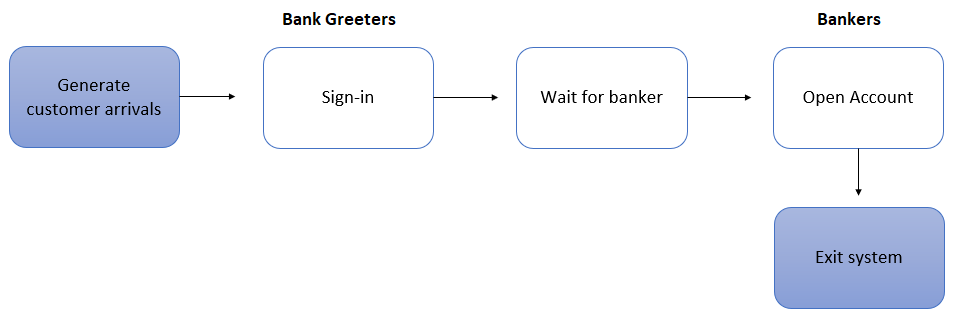

In [4]:
Image("images/bankflow.png")

The basic process of opening a bank account within a local branch (not from an online portal) involves the steps highlighted in the flowchart above.

1. A customer arrivies at a bank.
2. Customer is greeted by by bank staff to direct them to nature of their visit (for this scenario, opening an account).
3. Customer waits for next available banker.
4. Customer sits down wth banker to open an account.
5. Customer exits the system.

It is important to note that the Open Account portion consists of all the steps a banker would take to open a new account for a customer (i.e process the application, obtain signature cards, receive initial deposit, issue ATM/debit card, provide all account document to customer)

### Bank Model

In [5]:
# Create model evironment for bank
class Bank(object):
    def __init__(self, env, num_greeters, wait_area, num_bankers, rg):
        
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # Create a list to hold timestamps dictionaries
        self.timestamps_list = []
       
        # Create lists to hold occupancy tuples for customers waiting and customers being helped (time, occ)
        self.cust_waiting_list = [(0.0, 0.0)]
        self.cust_beinghelped_list = [(0.0, 0.0)]
        
        # Create resources for greeter and banker
        self.greeter = simpy.Resource(env, num_greeters)
        self.waiting = simpy.Resource(env, wait_area)
        self.banker = simpy.Resource(env, num_bankers)

    # Create process methods 
    def sign_in(self, customer):
        yield self.env.timeout(self.rg.normal(0.1, 0.05))

    def wait_for_banker(self, customer):
        yield self.env.timeout(self.rg.exponential(0.2))
        
    def open_account(self, customer):
        yield self.env.timeout(self.rg.exponential(1.0))


### Open Bank Account Function

In [6]:
def open_account(env, customer, bank, rg):
    # Customer arrives to bank
    arrival_ts = env.now

    # Request a greeter to direct customer to wait for banker
    with bank.greeter.request() as request:
        yield request
        got_greeter_ts = env.now
        yield env.process(bank.sign_in(customer))
        release_greeter_ts = env.now


    # Wait no more than 15 minutes for next available banker
    with bank.waiting.request() as request:
        yield request
        wait_time = env.now - release_greeter_ts
    if wait_time < 15:
        # Wait not more than 15 minuts
        yield env.timeout(15 - wait_time)
        # Wait random amount beyond 15 minutes
        yield env.process(bank.wait_for_banker(customer))
        release_wait_time = env.now

        # Update waiting and being helped by banker lists by 1
   
        bank.cust_waiting_list.append((env.now, bank.cust_waiting_list[-1][1] + 1))

        bank.cust_waiting_list.append((env.now, bank.cust_waiting_list[-1][1] - 1))

        bank.cust_beinghelped_list.append((env.now, bank.cust_beinghelped_list[-1][1] + 1))

    with bank.banker.request() as request:
        yield request
        got_banker_ts = env.now
        pre_cust = bank.cust_beinghelped_list[-1][1]
        new_cust = (env.now, pre_cust + 1)
        bank.cust_beinghelped_list.append(new_cust)
        yield env.process(bank.open_account(customer))
        release_banker_ts = env.now

        bank.cust_beinghelped_list.append((env.now, bank.cust_beinghelped_list[-1][1] - 1))
    
    exit_system_ts = env.now    

    # Create dictionary of timestamps
    timestamps = {'customer_id': customer,
                  'arrival_ts': arrival_ts,
                  'got_greeter_ts': got_greeter_ts,
                  'release_greeter_ts': release_greeter_ts,
                  'wait_time': wait_time,
                  'release_wait_time': release_wait_time,
                  'got_banker_ts': got_banker_ts,
                  'release_banker_ts': release_banker_ts,
                  'exit_system_ts': exit_system_ts}
    
    bank.timestamps_list.append(timestamps)

### Function to run bank hour times

In [7]:
# Running bank for specific hours

def run_bank(env, bank, mean_interarrival_time, rg, 
               stoptime=simpy.core.Infinity, max_arrivals=simpy.core.Infinity):
      
    # Create a counter to keep track of number of customer witha unique customer id
    customer = 0

    # Loop for generating customers
    while env.now < stoptime and customer < max_arrivals:

        # Generate next interarrival time
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New customer generated = update counter of customers
        customer += 1
        
        #print(f"Customer {customer} created at time {env.now}")

        env.process(open_account(env, customer, bank, rg))


In [8]:
def main():
    
    # Customers arriving per hour
    customers_per_hour = 5
    mean_interarrival_time = 1.0 / (customers_per_hour / 60.0)
  #  pct_first_dose = 0.50
    
    # Create a random number generator
    rg = default_rng(seed=4470)
    
    # Capacity levels 
    num_greeters = 1
    num_bankers = 5
    wait_area = 2
    
    # Hours of operation assuming 8 hours for branch
    stoptime = 480 
    
    # Create a simulation environment
    env = simpy.Environment()

    # Create a bank to simulate
    bank = Bank(env, num_greeters, wait_area, num_bankers, rg)
    
    # Generator function
    env.process(run_bank(env, bank, mean_interarrival_time, rg, stoptime=stoptime))

    # Run the simulation
    env.run()
  
    
    # Output log files 
    bank_customer_log_df = pd.DataFrame(bank.timestamps_list)
    bank_customer_log_df.to_csv('./output/bank_customer_log_df.csv', index=False)
    
    cust_waiting_df = pd.DataFrame(bank.cust_waiting_list, columns=['ts', 'occ'])
    cust_waiting_df.to_csv('./output/cust_waiting_df.csv', index=False)    
    
    cust_beinghelped_df = pd.DataFrame(bank.cust_beinghelped_list, columns=['ts', 'occ'])
    cust_beinghelped_df.to_csv('./output/cust_beinghelped_df.csv', index=False)
    

    # Note simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)


In [9]:
bank_end_time = main()

Simulation ended at time 498.7174296896807


Good news!  The simulation ran!!!

### Review Results

Bad news...the simulation ran a little weird.

Looking at the below results, the simulation allowed an arrival after 480 minutes.  The last customer id logged at 483.238397.  The wait time calculation is off and so is the calculation for the time it should take the open an account.  Any correction attempts to the code resulted in errors or negative intervals.  Alhtough the times within the intervals are off, the overall simulation time ranges between 15 to 20 minutes, which was close to the overall time I was aiming for to obtain for this model.

Overall, I was aiming for wait time of no more than 15 minutes and time with the banker to be no more than 20 minutes.  The overall time should be around 30 minutes, so clearly soemthing is wrong with the code.

In [11]:
bank_customer_log_df = pd.read_csv('./output/bank_customer_log_df.csv')
bank_customer_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         35 non-null     int64  
 1   arrival_ts          35 non-null     float64
 2   got_greeter_ts      35 non-null     float64
 3   release_greeter_ts  35 non-null     float64
 4   wait_time           35 non-null     float64
 5   release_wait_time   35 non-null     float64
 6   got_banker_ts       35 non-null     float64
 7   release_banker_ts   35 non-null     float64
 8   exit_system_ts      35 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 2.6 KB


In [12]:
bank_customer_log_df.head()

,customer_id,arrival_ts,got_greeter_ts,release_greeter_ts,wait_time,release_wait_time,got_banker_ts,release_banker_ts,exit_system_ts
0,1,9.329902,9.329902,9.355366,0.0,24.496339,24.496339,25.414548,25.414548
1,2,10.381414,10.381414,10.508986,0.0,25.542604,25.542604,25.582912,25.582912
2,3,14.770321,14.770321,14.964427,0.0,30.102841,30.102841,30.172707,30.172707
3,4,25.837589,25.837589,25.923394,0.0,40.950520,40.950520,41.201133,41.201133
4,5,48.354626,48.354626,48.408939,0.0,63.597459,63.597459,64.157129,64.157129


In [13]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_greeter'] = timestamp_df.loc[:, 'got_greeter_ts'] - timestamp_df.loc[:, 'arrival_ts']
    timestamp_df['waiting_for_banker_time'] = timestamp_df.loc[:, 'release_wait_time'] - timestamp_df.loc[:, 'wait_time']
    timestamp_df['open_account_time'] = timestamp_df.loc[:, 'release_banker_ts'] - timestamp_df.loc[:, 'got_banker_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'arrival_ts']
    
    return timestamp_df

In [14]:
bank_customer_log_df = compute_durations(bank_customer_log_df)
bank_customer_log_df

,customer_id,arrival_ts,got_greeter_ts,release_greeter_ts,wait_time,release_wait_time,got_banker_ts,release_banker_ts,exit_system_ts,wait_for_greeter,waiting_for_banker_time,open_account_time,time_in_system
0,1,9.329902,9.329902,9.355366,0.0,24.496339,24.496339,25.414548,25.414548,0.000000,24.496339,0.918209,16.084646
1,2,10.381414,10.381414,10.508986,0.0,25.542604,25.542604,25.582912,25.582912,0.000000,25.542604,0.040307,15.201497
2,3,14.770321,14.770321,14.964427,0.0,30.102841,30.102841,30.172707,30.172707,0.000000,30.102841,0.069866,15.402386
3,4,25.837589,25.837589,25.923394,0.0,40.950520,40.950520,41.201133,41.201133,0.000000,40.950520,0.250613,15.363544
4,5,48.354626,48.354626,48.408939,0.0,63.597459,63.597459,64.157129,64.157129,0.000000,63.597459,0.559670,15.802503
5,6,67.659899,67.659899,67.820890,0.0,82.875900,82.875900,82.943972,82.943972,0.000000,82.875900,0.068072,15.284073
6,7,74.887798,74.887798,75.010757,0.0,90.097273,90.097273,90.824748,90.824748,0.000000,90.097273,0.727476,15.936950
7,8,106.582379,106.582379,106.721493,0.0,121.954782,121.954782,122.864684,122.864684,0.000000,121.954782,0.909902,16.282305
8,10,124.143673,124.143673,124.212781,0.0,139.259668,139.259668,139.839038,139.839038,0.000000,139.259668,0.579370,15.695365
9,9,121.320879,121.320879,121.374144,0.0,136.636242,136.636242,140.452410,140.452410,0.000000,136.636242,3.816168,19.131531


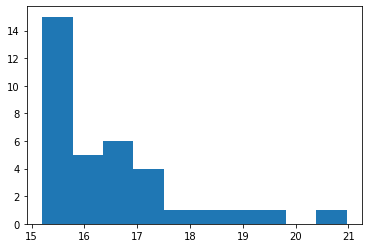

In [15]:
plt.hist(bank_customer_log_df['time_in_system']);

In [16]:
bank_customer_log_df.loc[:, ['wait_for_greeter', 'waiting_for_banker_time',
                              'open_account_time', 'time_in_system']].describe()

,wait_for_greeter,waiting_for_banker_time,open_account_time,time_in_system
count,35.000000,35.000000,35.000000,35.000000
mean,0.003618,233.152728,1.143760,16.441369
std,0.021401,133.285396,1.292448,1.309589
min,0.000000,24.496339,0.040307,15.201497
25%,0.000000,137.947955,0.226992,15.446318
50%,0.000000,213.327751,0.669575,15.936950
75%,0.000000,325.981588,1.577851,16.915181
max,0.126613,498.424497,5.749023,20.963831
